In [ ]:


import kagglehub


path = kagglehub.dataset_download("sohansakib75/cotton-kaggle")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cotton-kaggle


In [ ]:
import os
import kagglehub


path = kagglehub.dataset_download("sohansakib75/cotton-kaggle")

print("Dataset root path:", path)

# List folders and files inside
print("Contents inside dataset folder:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📂 {item}/")
    else:
        print(f"📄 {item}")


Dataset root path: /kaggle/input/cotton-kaggle
Contents inside dataset folder:
📂 Dataset/


In [ ]:
import os
import glob

dataset_path = os.path.join(path, "Dataset")

print("Path to Dataset folder:", dataset_path)


for subdir in sorted(os.listdir(dataset_path)):
    subpath = os.path.join(dataset_path, subdir)
    if os.path.isdir(subpath):
        # Count images by common formats
        image_files = glob.glob(os.path.join(subpath, "*.jpg")) + \
                      glob.glob(os.path.join(subpath, "*.jpeg")) + \
                      glob.glob(os.path.join(subpath, "*.png"))
        print(f"{subdir}: {len(image_files)} images")


Path to Dataset folder: /kaggle/input/cotton-kaggle/Dataset
Aphids: 400 images
Army worm: 400 images
Bacterial Blight: 400 images
Healthy: 400 images
Powdery Mildew: 400 images
Target spot: 400 images


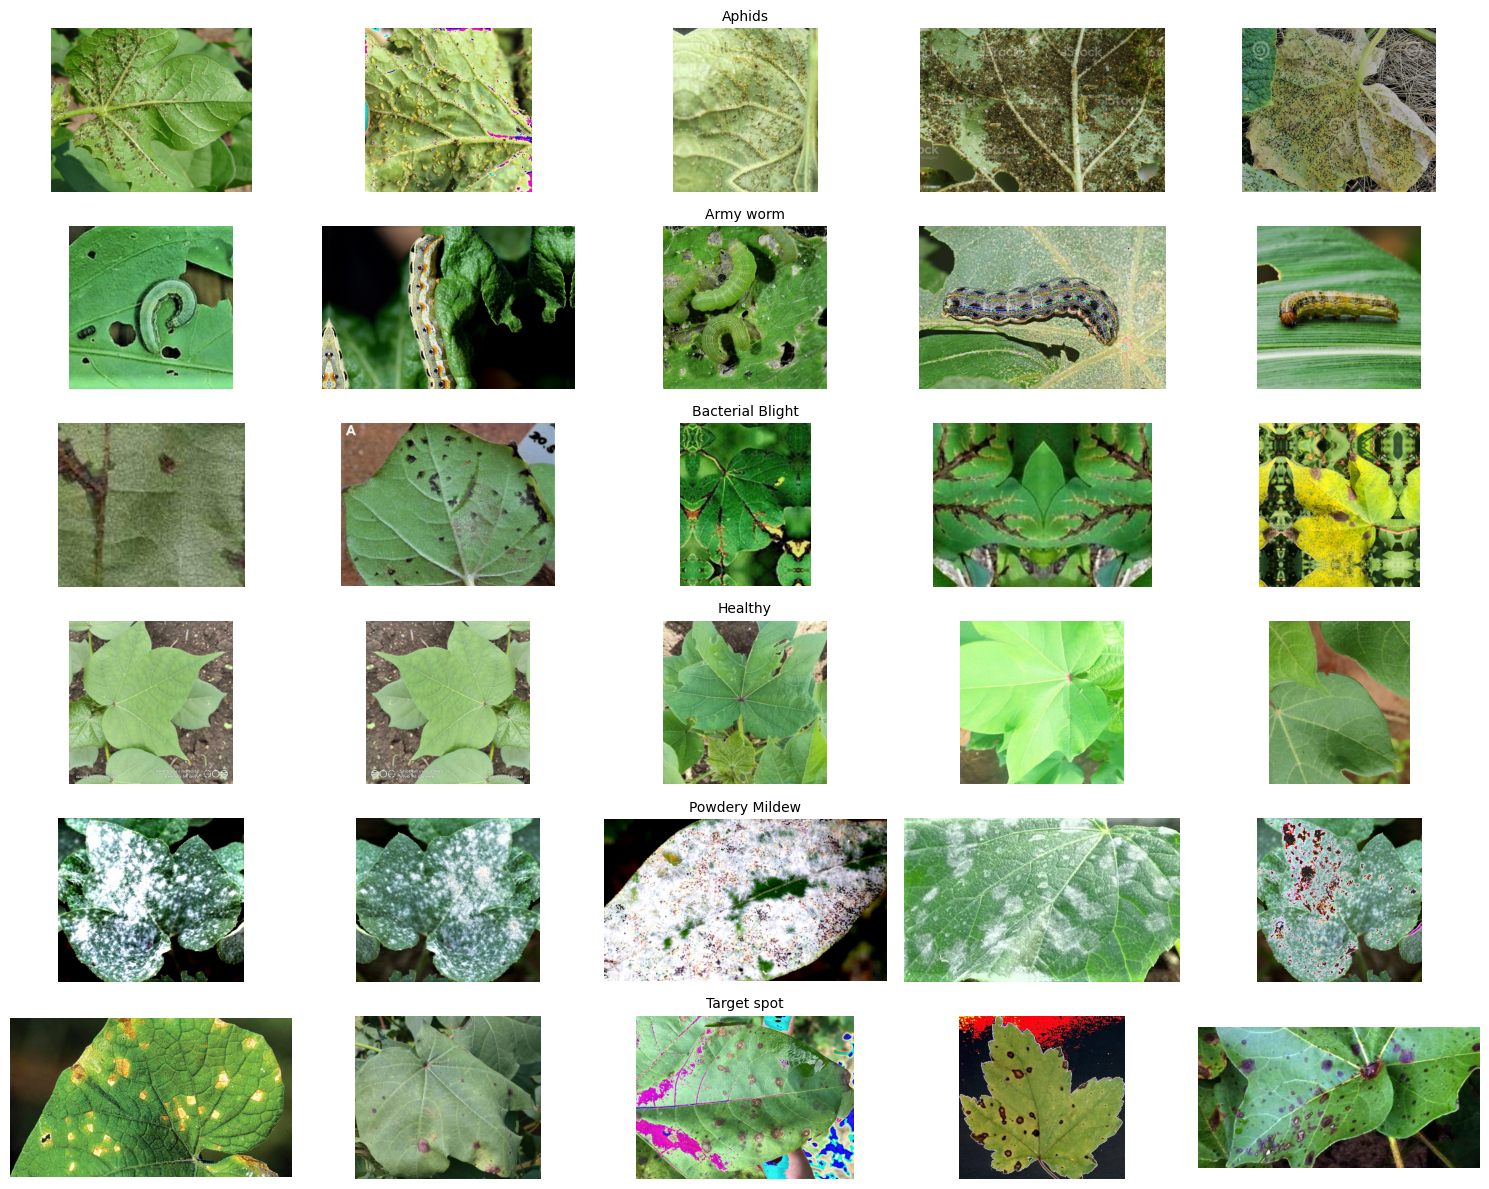

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import random

dataset_path = "/kaggle/input/cotton-kaggle/Dataset"

# Classes
classes = sorted(os.listdir(dataset_path))


fig, axes = plt.subplots(len(classes), 5, figsize=(15, 12))

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    image_files = glob.glob(os.path.join(cls_path, "*.jpg")) + \
                  glob.glob(os.path.join(cls_path, "*.jpeg")) + \
                  glob.glob(os.path.join(cls_path, "*.png"))


    sample_files = random.sample(image_files, 5)

    for j, img_path in enumerate(sample_files):
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 2:
            axes[i, j].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


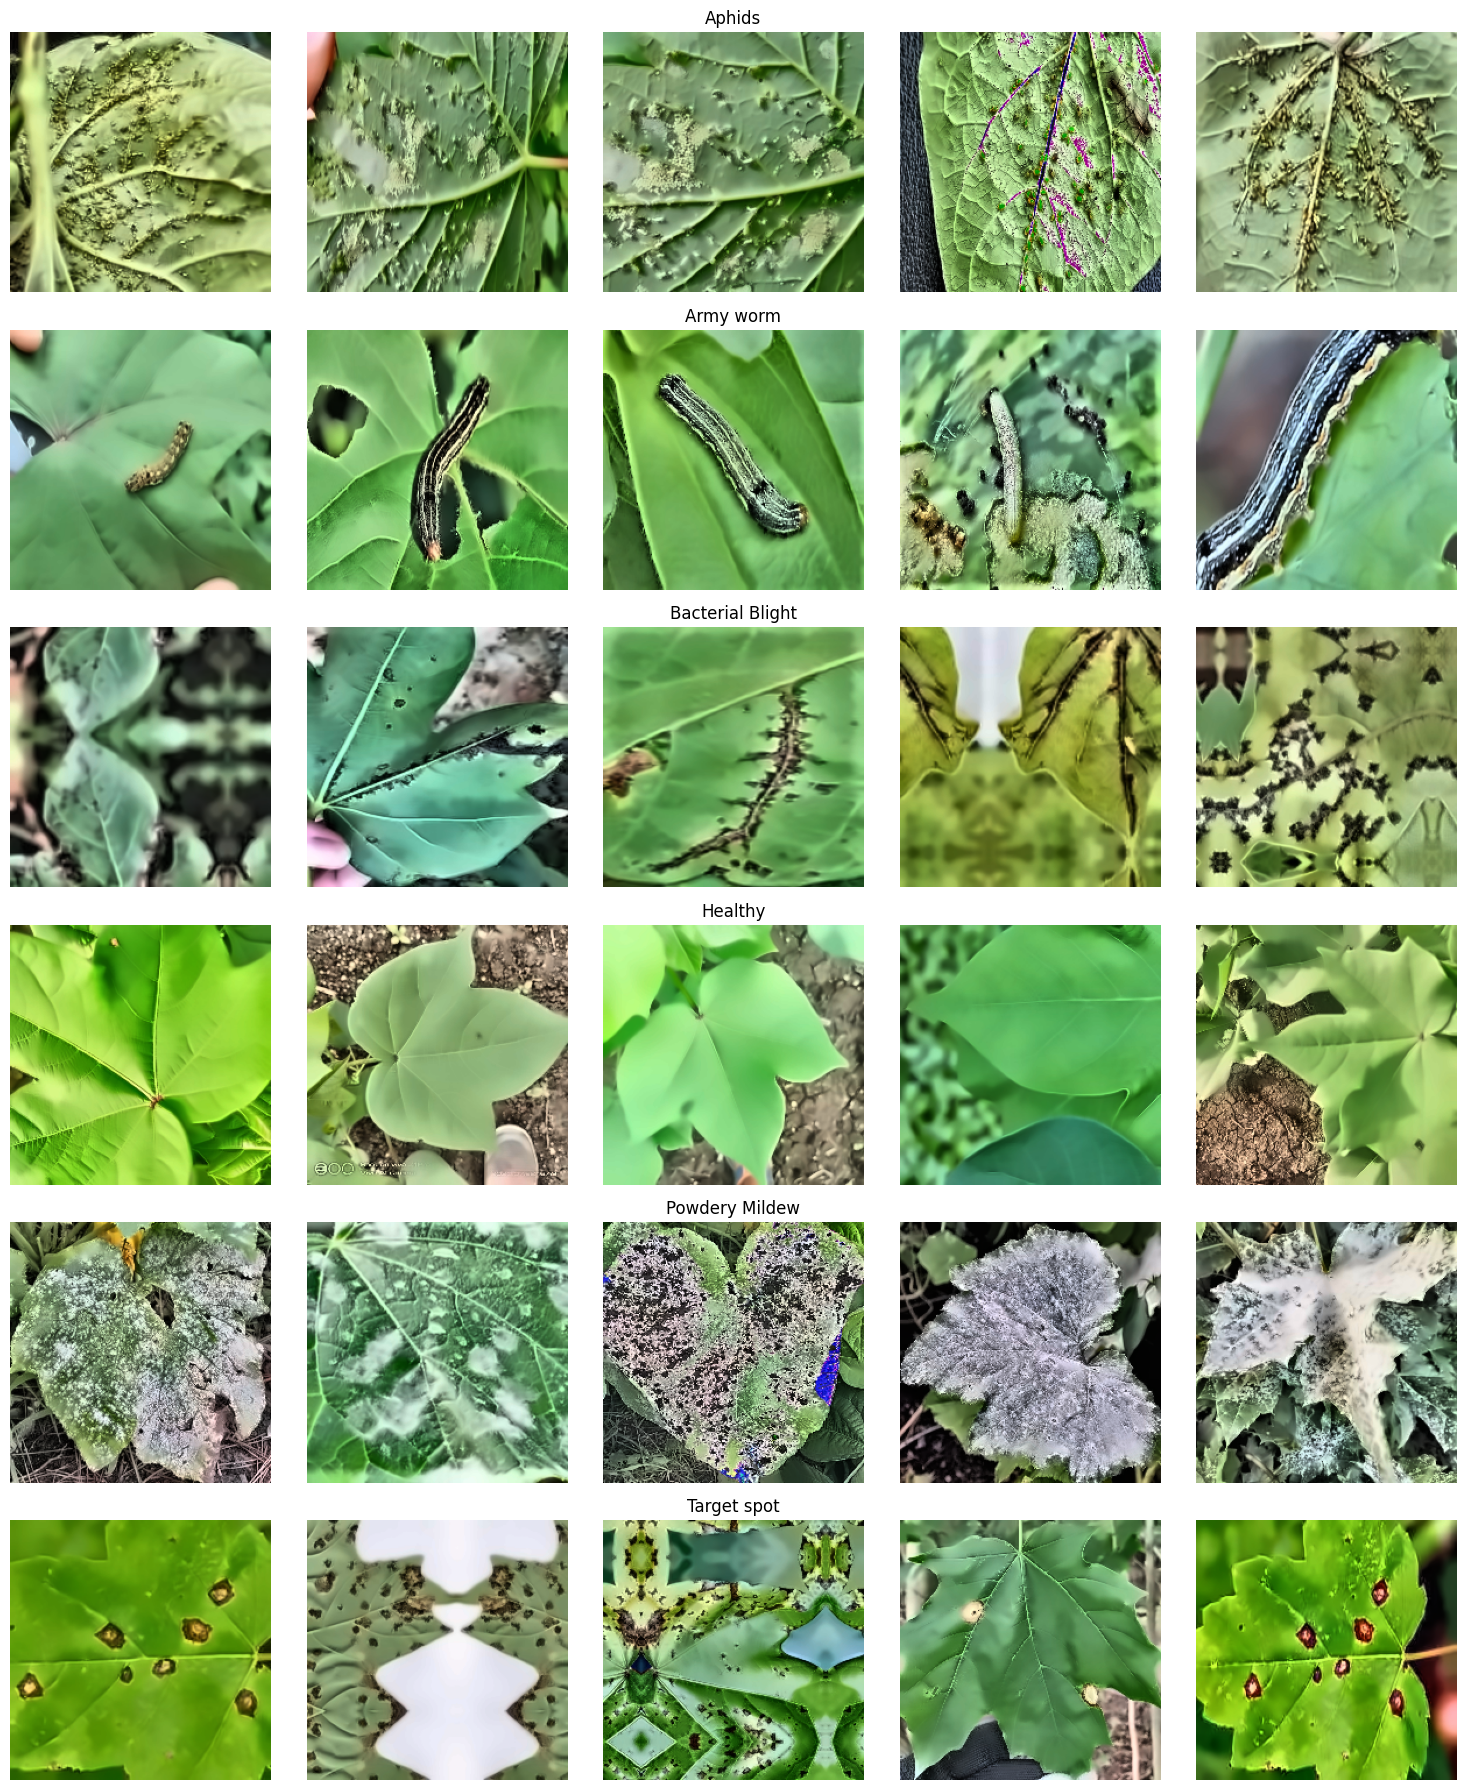


✅ Preprocessed images saved in: /kaggle/working/preprocessed_dataset


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Paths
input_dir = "/kaggle/input/cotton-kaggle/Dataset"
output_dir = "/kaggle/working/preprocessed_dataset"
os.makedirs(output_dir, exist_ok=True)

img_size = (224, 224)
num_samples = 5

classes = sorted(os.listdir(input_dir))
fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i, cls in enumerate(classes):
    cls_path = os.path.join(input_dir, cls)
    if os.path.isdir(cls_path):
        save_cls_path = os.path.join(output_dir, cls)
        os.makedirs(save_cls_path, exist_ok=True)

        files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        sample_files = random.sample(files, min(num_samples, len(files)))

        for j, file in enumerate(files):
            img_path = os.path.join(cls_path, file)
            img = cv2.imread(img_path)

            # 1️⃣ Resize
            img_resized = cv2.resize(img, img_size)

            # 2️⃣ CLAHE on Y channel
            yuv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YUV)
            yuv[:,:,0] = clahe.apply(yuv[:,:,0])
            img_clahe = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

            # 3️⃣ Non-Local Means Denoising
            img_denoised = cv2.fastNlMeansDenoisingColored(img_clahe, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

            # 4️⃣ Normalize to [0,1]
            img_final = img_denoised.astype(np.float32) / 255.0

            # Save preprocessed image
            save_img = (img_final * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(save_cls_path, file), save_img)

            # Plot sample images
            if file in sample_files:
                axes[i, sample_files.index(file)].imshow(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB))
                axes[i, sample_files.index(file)].axis("off")
                if sample_files.index(file) == num_samples // 2:
                    axes[i, sample_files.index(file)].set_title(cls, fontsize=12)

plt.tight_layout()
plt.show()
print("\n✅ Preprocessed images saved in:", output_dir)


In [ ]:
import os
import shutil
import random

# Preprocessed dataset path
preprocessed_dir = "/kaggle/working/preprocessed_dataset"

# Split paths
split_base = "/kaggle/working/cotton_split"
train_dir = os.path.join(split_base, "train")
val_dir   = os.path.join(split_base, "val")
test_dir  = os.path.join(split_base, "test")

# Create split folders
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

classes = sorted(os.listdir(preprocessed_dir))

for cls in classes:
    cls_path = os.path.join(preprocessed_dir, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(files)

    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    splits = {
        train_dir: files[:n_train],
        val_dir: files[n_train:n_train+n_val],
        test_dir: files[n_train+n_val:]
    }

    for split_folder, split_files in splits.items():
        cls_split_path = os.path.join(split_folder, cls)
        os.makedirs(cls_split_path, exist_ok=True)
        for f in split_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(cls_split_path, f))

print("✅ Dataset split into 80-10-10 and saved in:", split_base)


✅ Dataset split into 80-10-10 and saved in: /kaggle/working/cotton_split


In [ ]:
import os

split_base = "/kaggle/working/cotton_split"
splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(split_base, split)
    print(f"\n📂 {split.capitalize()} Split:")
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        print(f"{cls}: {num_images} images")



📂 Train Split:
Aphids: 320 images
Army worm: 320 images
Bacterial Blight: 320 images
Healthy: 320 images
Powdery Mildew: 320 images
Target spot: 320 images

📂 Val Split:
Aphids: 40 images
Army worm: 40 images
Bacterial Blight: 40 images
Healthy: 40 images
Powdery Mildew: 40 images
Target spot: 40 images

📂 Test Split:
Aphids: 40 images
Army worm: 40 images
Bacterial Blight: 40 images
Healthy: 40 images
Powdery Mildew: 40 images
Target spot: 40 images


In [ ]:
import os
import cv2
import numpy as np
import random

train_dir = "/kaggle/working/cotton_split/train"
aug_train_dir = "/kaggle/working/cotton_train_aug"
os.makedirs(aug_train_dir, exist_ok=True)


def random_flip(img):
    flip_code = random.choice([-1, 0, 1])
    return cv2.flip(img, flip_code)

def random_rotate(img):
    angle = random.uniform(-25, 25)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_zoom(img):
    zoom_factor = random.uniform(0.8, 1.2)
    h, w = img.shape[:2]
    new_h, new_w = int(h*zoom_factor), int(w*zoom_factor)
    img_resized = cv2.resize(img, (new_w, new_h))
    if zoom_factor < 1:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        img_padded = cv2.copyMakeBorder(img_resized, pad_h, h-new_h-pad_h,
                                        pad_w, w-new_w-pad_w, cv2.BORDER_REFLECT)
        return img_padded
    else:
        start_h = (new_h - h)//2
        start_w = (new_w - w)//2
        return img_resized[start_h:start_h+h, start_w:start_w+w]

def random_brightness(img):
    factor = random.uniform(0.7, 1.3)
    img = img.astype(np.float32) * factor
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

augmentations = [random_flip, random_rotate, random_zoom, random_brightness]

# Apply augmentations
classes = sorted(os.listdir(train_dir))
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    save_cls_path = os.path.join(aug_train_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    for file in os.listdir(cls_path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(cls_path, file)
        img = cv2.imread(img_path)

        # Save original
        cv2.imwrite(os.path.join(save_cls_path, file), img)

        # 3 random augmentations
        for k in range(3):
            aug_img = img.copy()
            aug_funcs = random.sample(augmentations, 2)
            for func in aug_funcs:
                aug_img = func(aug_img)
            filename, ext = os.path.splitext(file)
            aug_name = f"{filename}_aug{k+1}{ext}"
            cv2.imwrite(os.path.join(save_cls_path, aug_name), aug_img)

# Print image count per class
print("\n📊 Image count per class after augmentation:")
for cls in classes:
    cls_path = os.path.join(aug_train_dir, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    print(f"{cls}: {count} images")

print(f"\n✅ All train images and augmented images saved in: {aug_train_dir}")



📊 Image count per class after augmentation:
Aphids: 1280 images
Army worm: 1280 images
Bacterial Blight: 1280 images
Healthy: 1280 images
Powdery Mildew: 1280 images
Target spot: 1280 images

✅ All train images and augmented images saved in: /kaggle/working/cotton_train_aug


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 107MB/s]


Epoch 1/50 | Train Loss: 0.5897, Acc: 0.7964 | Val Loss: 0.2117, Acc: 0.9500
Epoch 2/50 | Train Loss: 0.2204, Acc: 0.9272 | Val Loss: 0.1365, Acc: 0.9625
Epoch 3/50 | Train Loss: 0.1583, Acc: 0.9496 | Val Loss: 0.1138, Acc: 0.9625
Epoch 4/50 | Train Loss: 0.1348, Acc: 0.9542 | Val Loss: 0.1316, Acc: 0.9625
Epoch 5/50 | Train Loss: 0.0952, Acc: 0.9690 | Val Loss: 0.1097, Acc: 0.9708
Epoch 6/50 | Train Loss: 0.0918, Acc: 0.9703 | Val Loss: 0.1261, Acc: 0.9667
Epoch 7/50 | Train Loss: 0.0842, Acc: 0.9724 | Val Loss: 0.1457, Acc: 0.9667
Epoch 8/50 | Train Loss: 0.0801, Acc: 0.9740 | Val Loss: 0.1484, Acc: 0.9583
Epoch 9/50 | Train Loss: 0.0669, Acc: 0.9770 | Val Loss: 0.1378, Acc: 0.9625
Epoch 10/50 | Train Loss: 0.0634, Acc: 0.9789 | Val Loss: 0.1492, Acc: 0.9667
Early stopping triggered

✅ Training complete. Total time: 136.17s

📄 Train Classification Report:
                  precision    recall  f1-score   support

          Aphids     0.9922    0.9961    0.9942      1280
       Army w

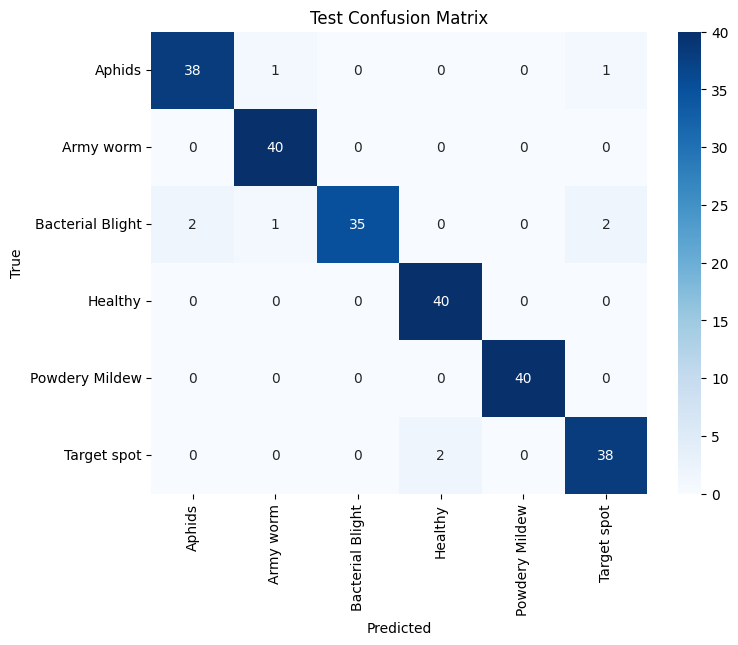


📊 Class-wise ROC AUC & PR AUC (Test):
              Class ROC AUC  PR AUC
0            Aphids  0.9948  0.9839
1         Army worm  0.9994  0.9969
2  Bacterial Blight  0.9981  0.9915
3           Healthy  1.0000  1.0000
4    Powdery Mildew  1.0000  1.0000
5       Target spot  0.9946  0.9853
Inference time: 0.40s | Per sample: 0.0017s | GPU Mem: 94.55MB | RAM: 2136.94MB

Cohen's Kappa: 0.9550
Brier Score: 0.0097
Accuracy 95% CI: [0.1208,0.2167]
T-test class0 vs class1: stat=-0.2407, p=0.8099
Mean PPV: 0.9636 | Mean NPV: 0.9926


In [ ]:
import os, time, psutil
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, brier_score_loss
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# 1️⃣ Dataset
# ----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder('/kaggle/working/cotton_train_aug', transform=transform)
val_dataset   = datasets.ImageFolder('/kaggle/working/cotton_split/val', transform=transform)
test_dataset  = datasets.ImageFolder('/kaggle/working/cotton_split/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = train_dataset.classes
num_classes = len(class_names)

# ----------------------
# 2️⃣ Multi-Head Self-Attention
# ----------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=4, dropout=0.3):
        super().__init__()
        assert in_channels % num_heads == 0, f"in_channels ({in_channels}) must be divisible by num_heads ({num_heads})"
        self.mha = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        b, c, h, w = x.size()
        x_flat = x.view(b, c, h*w).permute(0,2,1)  # [B, HW, C]
        attn_out, _ = self.mha(x_flat, x_flat, x_flat)
        attn_out = self.dropout(attn_out)
        attn_out = self.norm(attn_out + x_flat)
        out = attn_out.permute(0,2,1).view(b, c, h, w)
        return out

# ----------------------
# 3️⃣ ShuffleNetV2 + MHSA Model
# ----------------------
class ShuffleNetV2_MHSA(nn.Module):
    def __init__(self, num_classes, num_heads=4, dropout=0.3, freeze_backbone=True):
        super().__init__()
        self.backbone = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        self.backbone.fc = nn.Identity()
        self.mhsa = MultiHeadSelfAttention(in_channels=1024, num_heads=num_heads, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        attn_features = self.mhsa(features)
        out = self.classifier(attn_features)
        return out

# ----------------------
# 4️⃣ Instantiate model, criterion, optimizer
# ----------------------
model = ShuffleNetV2_MHSA(num_classes=num_classes, num_heads=4, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# ----------------------
# 5️⃣ Training loop
# ----------------------
num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
train_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_shufflenetv2_mhsa.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered")
            break

train_time = time.time() - train_start_time
print(f"\n✅ Training complete. Total time: {train_time:.2f}s")

# ----------------------
# 6️⃣ Load best model
# ----------------------
model.load_state_dict(torch.load('best_shufflenetv2_mhsa.pth'))
model.eval()

# ----------------------
# 7️⃣ Prediction helper
# ----------------------
def get_preds(loader):
    labels_list, preds_list, probs_list = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
    return np.array(labels_list), np.array(preds_list), np.array(probs_list)

train_labels, train_preds, train_probs = get_preds(train_loader)
val_labels, val_preds, val_probs       = get_preds(val_loader)
test_labels, test_preds, test_probs    = get_preds(test_loader)

# ----------------------
# 8️⃣ Classification Reports
# ----------------------
print("\n📄 Train Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names, digits=4))
print("\n📄 Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))
print("\n📄 Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# ----------------------
# 9️⃣ Confusion Matrix
# ----------------------
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()

# ----------------------
# 🔟 ROC & PR AUC
# ----------------------
test_labels_onehot = np.eye(num_classes)[test_labels]
roc_auc_list = [roc_auc_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
pr_auc_list  = [average_precision_score(test_labels_onehot[:,i], test_probs[:,i]) for i in range(num_classes)]
auc_df = pd.DataFrame({"Class": class_names, "ROC AUC": [f"{x:.4f}" for x in roc_auc_list], "PR AUC": [f"{x:.4f}" for x in pr_auc_list]})
print("\n📊 Class-wise ROC AUC & PR AUC (Test):")
print(auc_df)

# ----------------------
# 1️⃣1️⃣ Inference time & memory
# ----------------------
start_inf = time.time(); _ = get_preds(test_loader)
inf_time = time.time()-start_inf
inf_time_per_sample = inf_time / len(test_dataset)
mem_usage = torch.cuda.memory_allocated()/1024**2 if torch.cuda.is_available() else 0
ram_usage = psutil.virtual_memory().used/1024**2
print(f"Inference time: {inf_time:.2f}s | Per sample: {inf_time_per_sample:.4f}s | GPU Mem: {mem_usage:.2f}MB | RAM: {ram_usage:.2f}MB")

# ----------------------
# 1️⃣2️⃣ Kappa, Brier, PPV, NPV, Accuracy CI, T-test
# ----------------------
kappa = cohen_kappa_score(test_labels, test_preds)
brier = brier_score_loss(test_labels_onehot.flatten(), test_probs.flatten())
n_samples = len(test_labels)
boot_acc = [np.mean(test_labels[np.random.choice(n_samples, n_samples)] == test_preds[np.random.choice(n_samples, n_samples)]) for _ in range(1000)]
ci_low, ci_high = np.percentile(boot_acc, [2.5,97.5])
ttest_res = ttest_ind(test_probs[:,0], test_probs[:,1])
cm = confusion_matrix(test_labels, test_preds)
TP = np.diag(cm); FP = cm.sum(axis=0)-TP; FN = cm.sum(axis=1)-TP; TN = cm.sum()-(TP+FP+FN)
PPV = TP/(TP+FP+1e-8); NPV=TN/(TN+FN+1e-8)
print(f"\nCohen's Kappa: {kappa:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"Accuracy 95% CI: [{ci_low:.4f},{ci_high:.4f}]")
print(f"T-test class0 vs class1: stat={ttest_res.statistic:.4f}, p={ttest_res.pvalue:.4f}")
print(f"Mean PPV: {np.mean(PPV):.4f} | Mean NPV: {np.mean(NPV):.4f}")
